<a href="https://colab.research.google.com/github/Mikaykay/DS-Unit-2-Linear-Models/blob/master/Unit2_Sprint1_Module3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [2]:
# import libraries
import pandas as pd
import numpy as np
import sys
import warnings
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [3]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols, date_parser = ['SALE DATE'])

    # SALE DATE turn into DatetimeIndex
    df = df.set_index(pd.to_datetime(df['SALE DATE']))

    # BOROUGH from int -> object
    df['BOROUGH'] = df['BOROUGH'].astype('object')

    # SALE PRICE from object -> int
    df['SALE PRICE'] = df['SALE PRICE'].str.replace("[^a-zA-Z0-9]", "").astype('int')
    
    # Only include '01 ONE FAMILY DWELLINGS' and propertires with SALE PRICE between 100,000 and 2,000,000
    df = df.loc[(df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS')&(df['SALE PRICE']>100000)&(df['SALE PRICE']<2000000)]

    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'


**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [4]:
df = wrangle(filepath)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
SALE DATE,,,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1325.0,1930.0,550000,01/01/2019
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000,01/01/2019
2019-01-02,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,2043.0,1925.0,810000,01/02/2019
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000,01/02/2019
2019-01-02,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1872.0,1940.0,620000,01/02/2019


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [5]:
# Perform your exploratory data analysis here and
# modify the wrangle function above


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [6]:
target = 'SALE PRICE'
y = df[target]
X = df.drop(columns=target)


**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [7]:
# Create a cutoff variable without 

cutoff = '2019-04-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [8]:
y_pred = [y_train.mean()]*len(y_train)

baseline_mae = mean_absolute_error(y_train,y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 214721.52773001452


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [9]:
# Step 1: Import your transformer class
# from category_encoders import OneHotEncoder

# Step 2: Instantiate your transformer
ohe = OneHotEncoder(use_cat_names=True)

# Step 3: Fit your transformer to the training data
ohe.fit(X_train)

# Step 4: Transform my training and test data
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [10]:
# Step 1: Import predictor class
# from sklearn.linear_model import LinearRegression

# Step 2: Instantiate predictor
model_lr = LinearRegression()

# Step 3: Fit predictor on the (training) data
model_lr.fit(XT_train,y_train)

y_pred_train_lr = model_lr.predict(XT_train)
y_pred_test_lr = model_lr.predict(XT_test)

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [11]:
# Step 1: Import predictor class

# Step 2: Instantiate predictor and setting alpha
model_r = Ridge(alpha = 0.5)

# Step 3: Fit predictor on the (training) data
model_r.fit(XT_train, y_train)

y_pred_train_r = model_r.predict(XT_train)
y_pred_test_r = model_r.predict(XT_test)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [12]:
training_mae_lr = mean_absolute_error(y_train,y_pred_train_lr)
test_mae_lr = mean_absolute_error(y_test,y_pred_test_lr)

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 123365.6743119266
Linear Test MAE: 2286795316631.2095


**Task 10:** Check the training and test metrics for `model_r`.

In [13]:
training_mae_r = mean_absolute_error(y_train,y_pred_train_r)
test_mae_r = mean_absolute_error(y_test,y_pred_test_r)

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 123569.12241434939
Ridge Test MAE: 140991.82605019872


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [16]:
# Caculate R^2 score
train_r2 = model_r.score(XT_train,y_train)
test_r2 = model_r.score(XT_test,y_test)

print('Ridge R2:', train_r2)
print('Ridge R2:', test_r2)

Ridge R2: 0.6362138194664516
Ridge R2: 0.4750380412599652


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

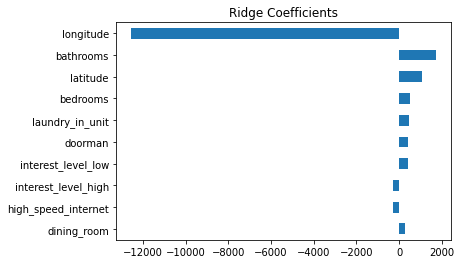

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

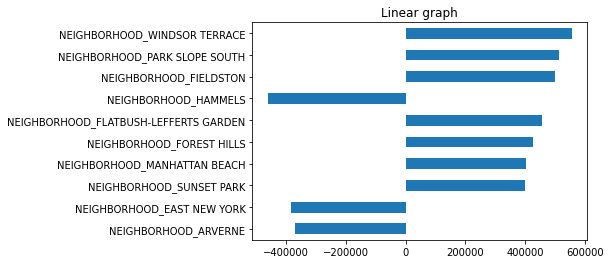

In [19]:
coefficients_r = model_r.coef_
features = ohe.get_feature_names()
feature_importance_r = pd.Series(coefficients_r, index=features).sort_values(key=abs)
feature_importance_r
feature_importance_r.tail(10).plot(kind = 'barh')
plt.title("Ridge Coefficients")
plt.show()